In [48]:
import os
import copy
import pandas as pd
import numpy as np
from experiments import ExperimentModule
from experiments import save_plots, load_qasm_circuit
from sanchez_ansatz import SanchezAnsatz
from qiskit import transpile
from experiments.create_state import get_state
import matplotlib.pyplot as plt
from itertools import product
from datetime import datetime
from typing import Tuple
from qiskit_aer import Aer

%matplotlib inline

In [49]:
results_dir = "results/COBYLA/no_ent/distributions"
run_range = list(range(1, 11))
#qubit_range = [3, 4, 5, 6, 7, 8]
qubit_range = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

# EPS values are mapped separately
#eps_values = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]
eps_values = [0.5, 0.1, 0.05, 0.01]

In [50]:
def load_results(results_dir, state_type, qubit_range, eps_values) -> Tuple[dict,dict]:
    #[0.5, 0.1, 0.05, 0.01, 0.005, 0.001]
    original_results_dict = {
        "num_qubits": [],
        0.5: [],
        0.1: [],
        0.05: [],
        0.01: [],
    }

    modified_results_dict = copy.deepcopy(original_results_dict)

    for (r_dir, st_type, num_qubits, eps) in product([results_dir], [state_type], qubit_range, eps_values):
        if not num_qubits in original_results_dict["num_qubits"]: 
            original_results_dict["num_qubits"] += [num_qubits]
            modified_results_dict["num_qubits"] += [num_qubits]

        original_results_dict[eps] += [[]]
        modified_results_dict[eps] += [[]]

        for run_idx in run_range:
            fid_loss_original = np.loadtxt(f"{results_dir}/{st_type}/run_{run_idx}/csv/original_fidloss_{num_qubits}qb_{eps}eps.csv", delimiter=",")
            data_original = fid_loss_original[-1][-1] if len(fid_loss_original.shape) > 1 else fid_loss_original[-1]
            original_results_dict[eps][-1] += [data_original.round(4)]

            fid_loss_modified = np.loadtxt(f"{results_dir}/{st_type}/run_{run_idx}/csv/modified_fidloss_{num_qubits}qb_{eps}eps.csv", delimiter=",")
            data_modified = fid_loss_modified[-1][-1] if len(fid_loss_modified.shape) > 1 else fid_loss_modified[-1]
            modified_results_dict[eps][-1]+= [data_modified.round(4)]
    
    return original_results_dict, modified_results_dict


def compute_statistics(results_dict: dict) -> Tuple[dict, dict]: 
    default_dict = {
        "num_qubits": qubit_range,
        0.5: [],
        0.1: [],
        0.05: [],
        0.01: [],
    }
    mean_results_dict = copy.deepcopy(default_dict)
    stds_results_dict = copy.deepcopy(default_dict)

    #stds_original_results_dict = copy.deepcopy(default_dict)
    #stds_modified_results_dict = copy.deepcopy(default_dict)

    for eps in eps_values:
        mean_results_dict[eps] = np.mean(results_dict[eps], axis=1)
        stds_results_dict[eps] = np.std(results_dict[eps], axis=1).round(2)

        #mean_modified_results_dict[eps] = np.mean(modified_results_dict[eps], axis=1)
        #stds_modified_results_dict[eps] = np.std(modified_results_dict[eps], axis=1).round(2)
    return mean_results_dict, stds_results_dict


def to_dataframe(results_dict: dict) -> pd.DataFrame:
    df_results = pd.DataFrame(results_dict)
    df_results = df_results.set_index("num_qubits")
    return df_results

def get_state_vector(quantum_circuit):
    sv_sim = Aer.get_backend("statevector_simulator")
    job = sv_sim.run(quantum_circuit)
    result = job.result()
    state_vector = result.get_statevector()
    return state_vector.data

def get_loaded_states(results_dir, state_type, execution_range, n_qubits, eps_value) -> Tuple[np.ndarray, np.ndarray]:

    sv_list_original = []
    sv_list_modified = []

    for n_run in range(1, execution_range+1):
        # original_circuit_file_name = os.path.join(results_dir, state_type, f"run_{n_run}", "circuits", f"original_curcuit_{n_qubits}qb_{eps_value}eps.pkl")
        # original_circuit = load_circuit(original_circuit_file_name)
        original_circuit_file_name = os.path.join(results_dir, state_type, f"run_{n_run}", "circuits", f"original_curcuit_{n_qubits}qb_{eps_value}eps.qasm")
        original_circuit = load_qasm_circuit(original_circuit_file_name)

        # Because we are now loading qasm circuits we do not need to assign all parameters
        # parameters_original_filename = os.path.join(results_dir, state_type, f"run_{n_run}", "csv", f"original_xbest_{n_qubits}qb_{eps_value}eps.csv")
        # parameters_original = np.loadtxt(parameters_original_filename, delimiter=",")


        # modified_circuit_file_name = os.path.join(results_dir, state_type, "run_10", "circuits", f"modified_curcuit_{n_qubits}qb_{eps_value}eps.pkl")
        # modified_circuit = load_circuit(modified_circuit_file_name)
        modified_circuit_file_name = os.path.join(results_dir, state_type, "run_10", "circuits", f"modified_curcuit_{n_qubits}qb_{eps_value}eps.qasm")
        modified_circuit = load_qasm_circuit(modified_circuit_file_name)

        # Because we are now loading qasm circuits we do not need to assign all parameters
        # parameters_modified_filename = os.path.join(results_dir, state_type, f"run_{n_run}", "csv", f"modified_xbest_{n_qubits}qb_{eps_value}eps.csv")
        # parameters_modified = np.loadtxt(parameters_modified_filename, delimiter=",")

        # p_original_circuit = original_circuit.assign_parameters(parameters_original)
        # sv_original = get_state_vector(p_original_circuit)
        sv_original = get_state_vector(original_circuit)
        sv_list_original += [sv_original]

        # p_modified_circuit = modified_circuit.assign_parameters(parameters_modified)
        # sv_modified = get_state_vector(p_modified_circuit)
        sv_modified = get_state_vector(modified_circuit)
        sv_list_modified += [sv_modified]

    sv_mean_original = np.mean(sv_list_original, axis=0)
    sv_std_original  = np.std(sv_list_original, axis=0)

    sv_mean_modified = np.mean(sv_list_modified, axis=0)
    sv_std_modified  = np.std(sv_list_original, axis=0)

    return (sv_mean_original, sv_std_original), (sv_mean_modified, sv_std_modified)

### Normal distribution $(\mu = 0.5, \sigma = 0.3)$

In [78]:
state_type = "normal"

In [79]:
original_results_dict, modified_results_dict = load_results(results_dir, state_type, qubit_range, eps_values)

mean_original_results_dict, stds_original_results_dict = compute_statistics(original_results_dict)
mean_modified_results_dict, stds_modified_results_dict = compute_statistics(modified_results_dict)

df_mean_original = to_dataframe(mean_original_results_dict)
df_stds_original = to_dataframe(stds_modified_results_dict)

df_mean_modified = to_dataframe(mean_modified_results_dict)
df_stds_modified = to_dataframe(stds_modified_results_dict)

In [80]:
display(df_mean_original)
display(df_mean_modified)

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.02650,0.02650,0.87320,0.87461
4,0.02770,0.02770,0.00561,0.94725
5,0.02670,0.02670,0.00650,0.00395
6,0.02590,0.02590,0.00651,0.00792
7,0.02550,0.02575,0.00641,0.00269
8,0.02520,0.02520,0.00640,0.00487
9,0.02510,0.02510,0.00657,0.00284
10,0.02510,0.02510,0.00640,0.10343
11,0.02500,0.02500,0.00658,0.00436


,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.0265,0.0265,0.0000,0.0000
4,0.0275,0.0275,0.0056,0.0000
5,0.0265,0.0265,0.7503,0.0013
6,0.0258,0.0258,0.0065,0.7501
7,0.0253,0.0253,0.5032,0.0016
8,0.0251,0.0251,0.0064,0.0016
9,0.0250,0.0250,0.0064,0.0016
10,0.0249,0.0249,0.0063,0.7504
11,0.0249,0.0249,0.7516,0.0016


In [81]:
df_mean_original < df_mean_modified

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,False,False,False,False
4,False,False,False,False
5,False,False,True,False
6,False,False,False,True
7,False,False,True,False
8,False,False,False,False
9,False,False,False,False
10,False,False,False,True
11,False,False,True,False


In [82]:
n_qubits = 15
eps_value = 0.05
execution_range = 10

(sv_mean_original, sv_std_original), (sv_mean_modified, sv_std_modified) = get_loaded_states(results_dir=results_dir, state_type=state_type, execution_range=execution_range, n_qubits=n_qubits, eps_value=eps_value)

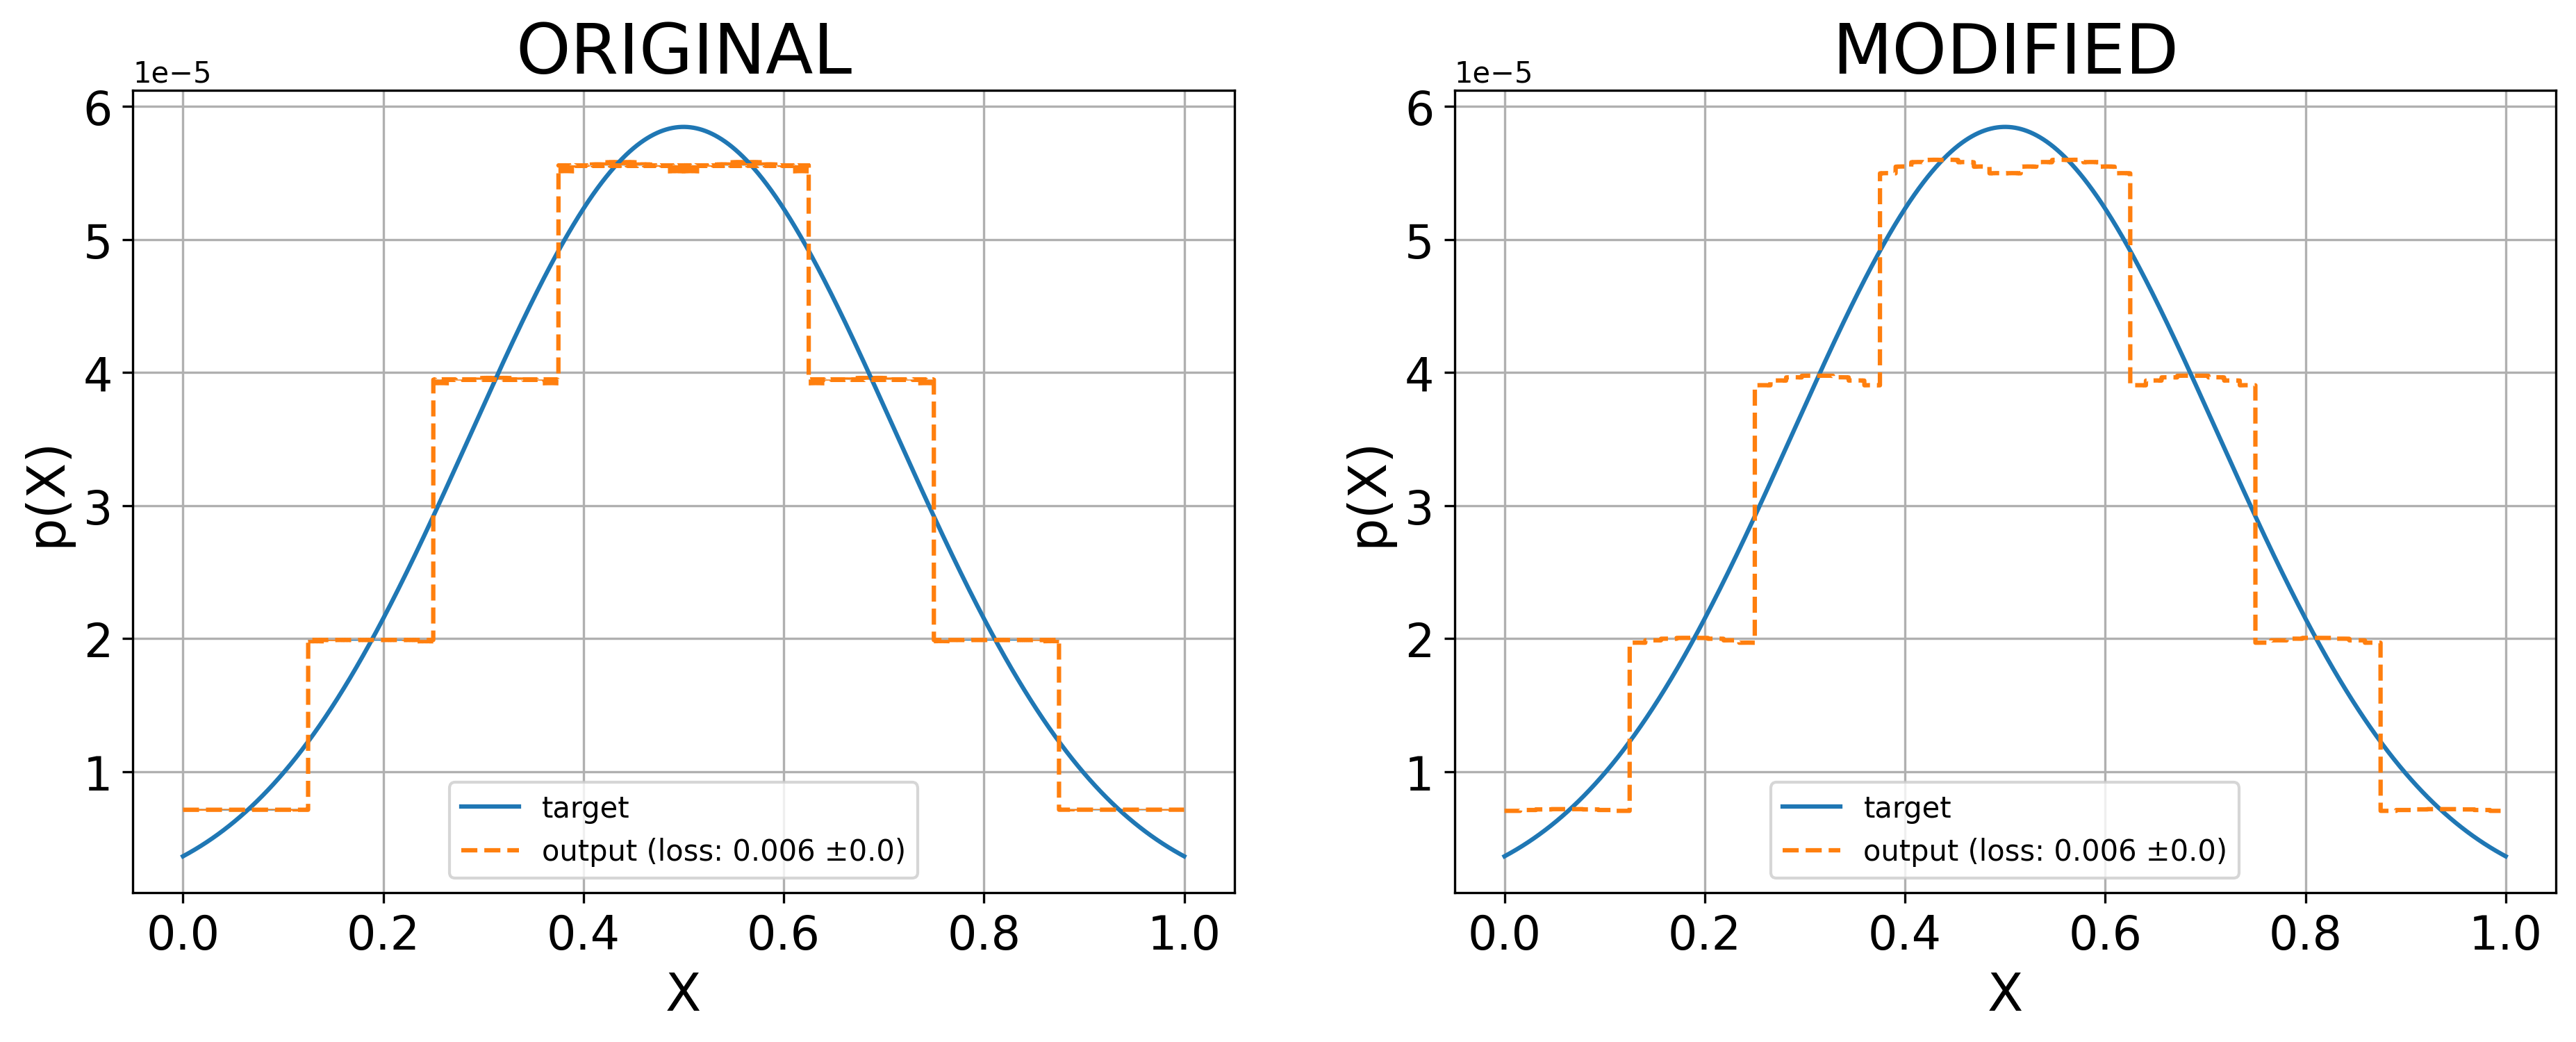

In [83]:
target_state = get_state(num_qubits=n_qubits, state_type=state_type, state_params={"x_points": (0, 1), "loc": 0.5, "scale": 0.3})


x_points = np.linspace(0, 1, 2**n_qubits)

target_freqs = np.abs(target_state)**2

#plt.ticklabel_format(axis="y", style="sci")
fig, axes = plt.subplots(1, 2, dpi=300)
fig.set_figheight(5)
fig.set_figwidth(15)
title_fontsize = 24
labels_fontsize= 18
ticks_fontsize = 16
axes[0].set_title("ORIGINAL", fontsize=title_fontsize)
axes[0].plot(x_points, target_freqs, label="target")
axes[0].plot(x_points, np.abs(sv_mean_original)**2, "--", label=f"output (loss: {round(df_mean_original.loc[n_qubits][eps_value], 3)} ±{round(df_stds_original.loc[n_qubits][eps_value], 2)})")
axes[0].grid()
axes[0].set_xlabel("X", fontsize=labels_fontsize)
axes[0].set_ylabel("p(X)", fontsize=labels_fontsize)
axes[0].tick_params(labelsize=ticks_fontsize)
#axes[0].set_ylim([0, 0.0002])
axes[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[0].legend(loc="best")

axes[1].set_title("MODIFIED", fontsize=title_fontsize)
axes[1].plot(x_points, target_freqs, label="target")
axes[1].plot(x_points, np.abs(sv_mean_modified)**2, "--", label=f"output (loss: {round(df_mean_modified.loc[n_qubits][eps_value], 3)} ±{round(df_stds_modified.loc[n_qubits][eps_value], 2)})")
axes[1].grid()
axes[1].set_xlabel("X", fontsize=labels_fontsize)
axes[1].set_ylabel("p(X)", fontsize=labels_fontsize)
axes[1].tick_params(labelsize=ticks_fontsize)
#axes[1].set_ylim([0, 0.0002])
axes[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[1].legend(loc="best")

### $log$-Normal Distribution $(s= 1, \mu = 0.1, \sigma = 0.3)$

In [57]:
state_type = "lognormal"

In [58]:
original_results_dict, modified_results_dict = load_results(results_dir, state_type, qubit_range, eps_values)

mean_original_results_dict, stds_original_results_dict = compute_statistics(original_results_dict)
mean_modified_results_dict, stds_modified_results_dict = compute_statistics(modified_results_dict)

df_mean_original = to_dataframe(mean_original_results_dict)
df_stds_original = to_dataframe(stds_modified_results_dict)

df_mean_modified = to_dataframe(mean_modified_results_dict)
df_stds_modified = to_dataframe(stds_modified_results_dict)

In [59]:
display(df_mean_original)
display(df_mean_modified)

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.15460,0.15460,0.95570,0.88206
4,0.21620,0.21620,0.04246,0.95214
5,0.22560,0.22560,0.03785,0.02515
6,0.22200,0.22200,0.03038,0.02255
7,0.21910,0.21910,0.02879,0.01912
8,0.21750,0.21750,0.02744,0.02421
9,0.21670,0.21670,0.02624,0.03511
10,0.29457,0.21620,0.12467,0.01890
11,0.21600,0.29174,0.12318,0.01697


,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.1546,0.1546,0.0000,0.0000
4,0.2111,0.2111,0.0400,0.0000
5,0.2221,0.2221,0.7722,0.0135
6,0.2194,0.2194,0.0282,0.7529
7,0.2171,0.2171,0.5148,0.0131
8,0.2157,0.2157,0.0248,0.0129
9,0.2150,0.2150,0.0243,0.0126
10,0.2146,0.2146,0.0240,0.7532
11,0.2144,0.2144,0.7561,0.0124


In [60]:
df_mean_original < df_mean_modified

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,False,False,False,False
4,False,False,False,False
5,False,False,True,False
6,False,False,False,True
7,False,False,True,False
8,False,False,False,False
9,False,False,False,False
10,False,False,False,True
11,False,False,True,False


In [61]:
n_qubits = 15
eps_value = 0.01
execution_range = 10

(sv_mean_original, sv_std_original), (sv_mean_modified, sv_std_modified) = get_loaded_states(results_dir=results_dir, state_type=state_type, execution_range=execution_range, n_qubits=n_qubits, eps_value=eps_value)

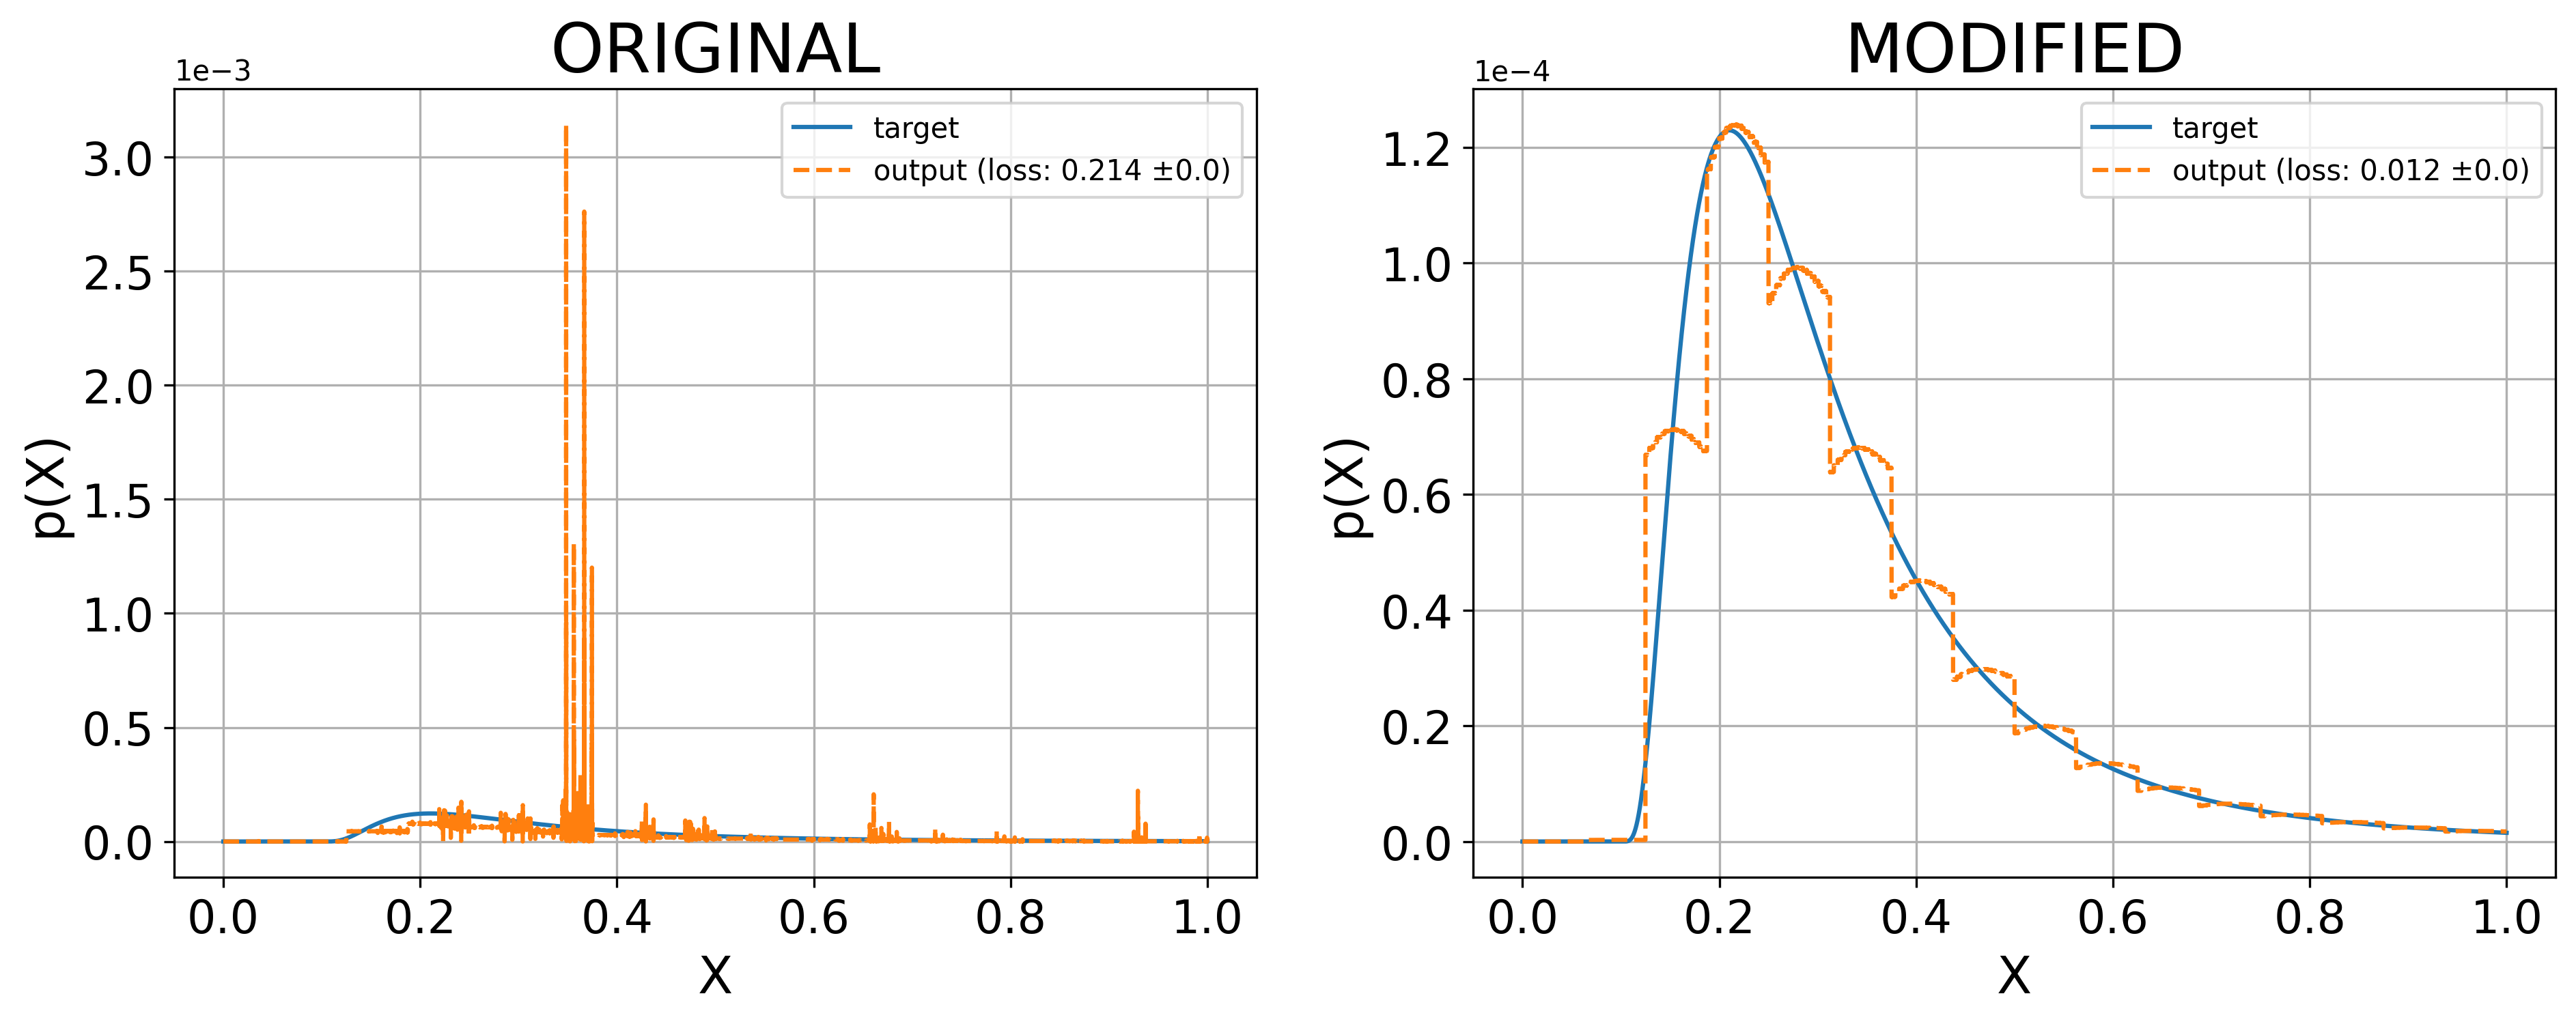

In [62]:
target_state = get_state(num_qubits=n_qubits, state_type=state_type, state_params={"x_points": (0, 1), "s": 1, "loc": 0.1, "scale": 0.3})


x_points = np.linspace(0, 1, 2**n_qubits)


target_freqs = np.abs(target_state)**2

#plt.ticklabel_format(axis="y", style="sci")
fig, axes = plt.subplots(1, 2, dpi=300)
fig.set_figheight(5)
fig.set_figwidth(15)
title_fontsize = 24
labels_fontsize= 18
ticks_fontsize = 16
axes[0].set_title("ORIGINAL", fontsize=title_fontsize)
axes[0].plot(x_points, target_freqs, label="target")
axes[0].plot(x_points, np.abs(sv_mean_original)**2, "--", label=f"output (loss: {round(df_mean_original.loc[n_qubits][eps_value], 3)} ±{round(df_stds_original.loc[n_qubits][eps_value], 2)})")
axes[0].grid()
axes[0].set_xlabel("X", fontsize=labels_fontsize)
axes[0].set_ylabel("p(X)", fontsize=labels_fontsize)
axes[0].tick_params(labelsize=ticks_fontsize)
#axes[0].set_ylim([0, 0.0002])
axes[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[0].legend(loc="best")

axes[1].set_title("MODIFIED", fontsize=title_fontsize)
axes[1].plot(x_points, target_freqs, label="target")
axes[1].plot(x_points, np.abs(sv_mean_modified)**2, "--", label=f"output (loss: {round(df_mean_modified.loc[n_qubits][eps_value], 3)} ±{round(df_stds_modified.loc[n_qubits][eps_value], 2)})")
axes[1].grid()
axes[1].set_xlabel("X", fontsize=labels_fontsize)
axes[1].set_ylabel("p(X)", fontsize=labels_fontsize)
axes[1].tick_params(labelsize=ticks_fontsize)
#axes[1].set_ylim([0, 0.0002])
axes[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[1].legend(loc="best")

### Bimodal Distribution $(\mu_1 = 0.25, \sigma_1 = 0.1; \mu_2 = 0.75, \sigma_2 = 0.15)$

In [63]:
state_type = "bimodal"

In [64]:
original_results_dict, modified_results_dict = load_results(results_dir, state_type, qubit_range, eps_values)

mean_original_results_dict, stds_original_results_dict = compute_statistics(original_results_dict)
mean_modified_results_dict, stds_modified_results_dict = compute_statistics(modified_results_dict)

df_mean_original = to_dataframe(mean_original_results_dict)
df_stds_original = to_dataframe(stds_modified_results_dict)

df_mean_modified = to_dataframe(mean_modified_results_dict)
df_stds_modified = to_dataframe(stds_modified_results_dict)

In [65]:
display(df_mean_original)
display(df_mean_modified)

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.15370,0.15370,0.80220,0.87092
4,0.19370,0.19370,0.03350,0.92528
5,0.19410,0.19410,0.03805,0.00928
6,0.19150,0.19150,0.03820,0.01406
7,0.18960,0.18960,0.03804,0.01286
8,0.18850,0.18851,0.03875,0.01849
9,0.18800,0.18800,0.03770,0.01932
10,0.18770,0.18770,0.03761,0.02761
11,0.18750,0.18753,0.04143,0.01247


,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.1537,0.1537,0.0000,0.0000
4,0.1925,0.1925,0.0335,0.0000
5,0.1930,0.1930,0.7515,0.0078
6,0.1905,0.1905,0.0380,0.7511
7,0.1887,0.1887,0.5190,0.0097
8,0.1877,0.1877,0.0376,0.0097
9,0.1872,0.1872,0.0374,0.0097
10,0.1869,0.1869,0.0374,0.7525
11,0.1868,0.1868,0.7594,0.0097


In [66]:
display(df_stds_original)
display(df_stds_modified)

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0


,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0


In [67]:
df_mean_original < df_mean_modified

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,False,False,False,False
4,False,False,False,False
5,False,False,True,False
6,False,False,False,True
7,False,False,True,False
8,False,False,False,False
9,False,False,False,False
10,False,False,False,True
11,False,False,True,False


In [68]:
n_qubits = 15
eps_value = 0.01
execution_range = 10

(sv_mean_original, sv_std_original), (sv_mean_modified, sv_std_modified) = get_loaded_states(results_dir=results_dir, state_type=state_type, execution_range=execution_range, n_qubits=n_qubits, eps_value=eps_value)

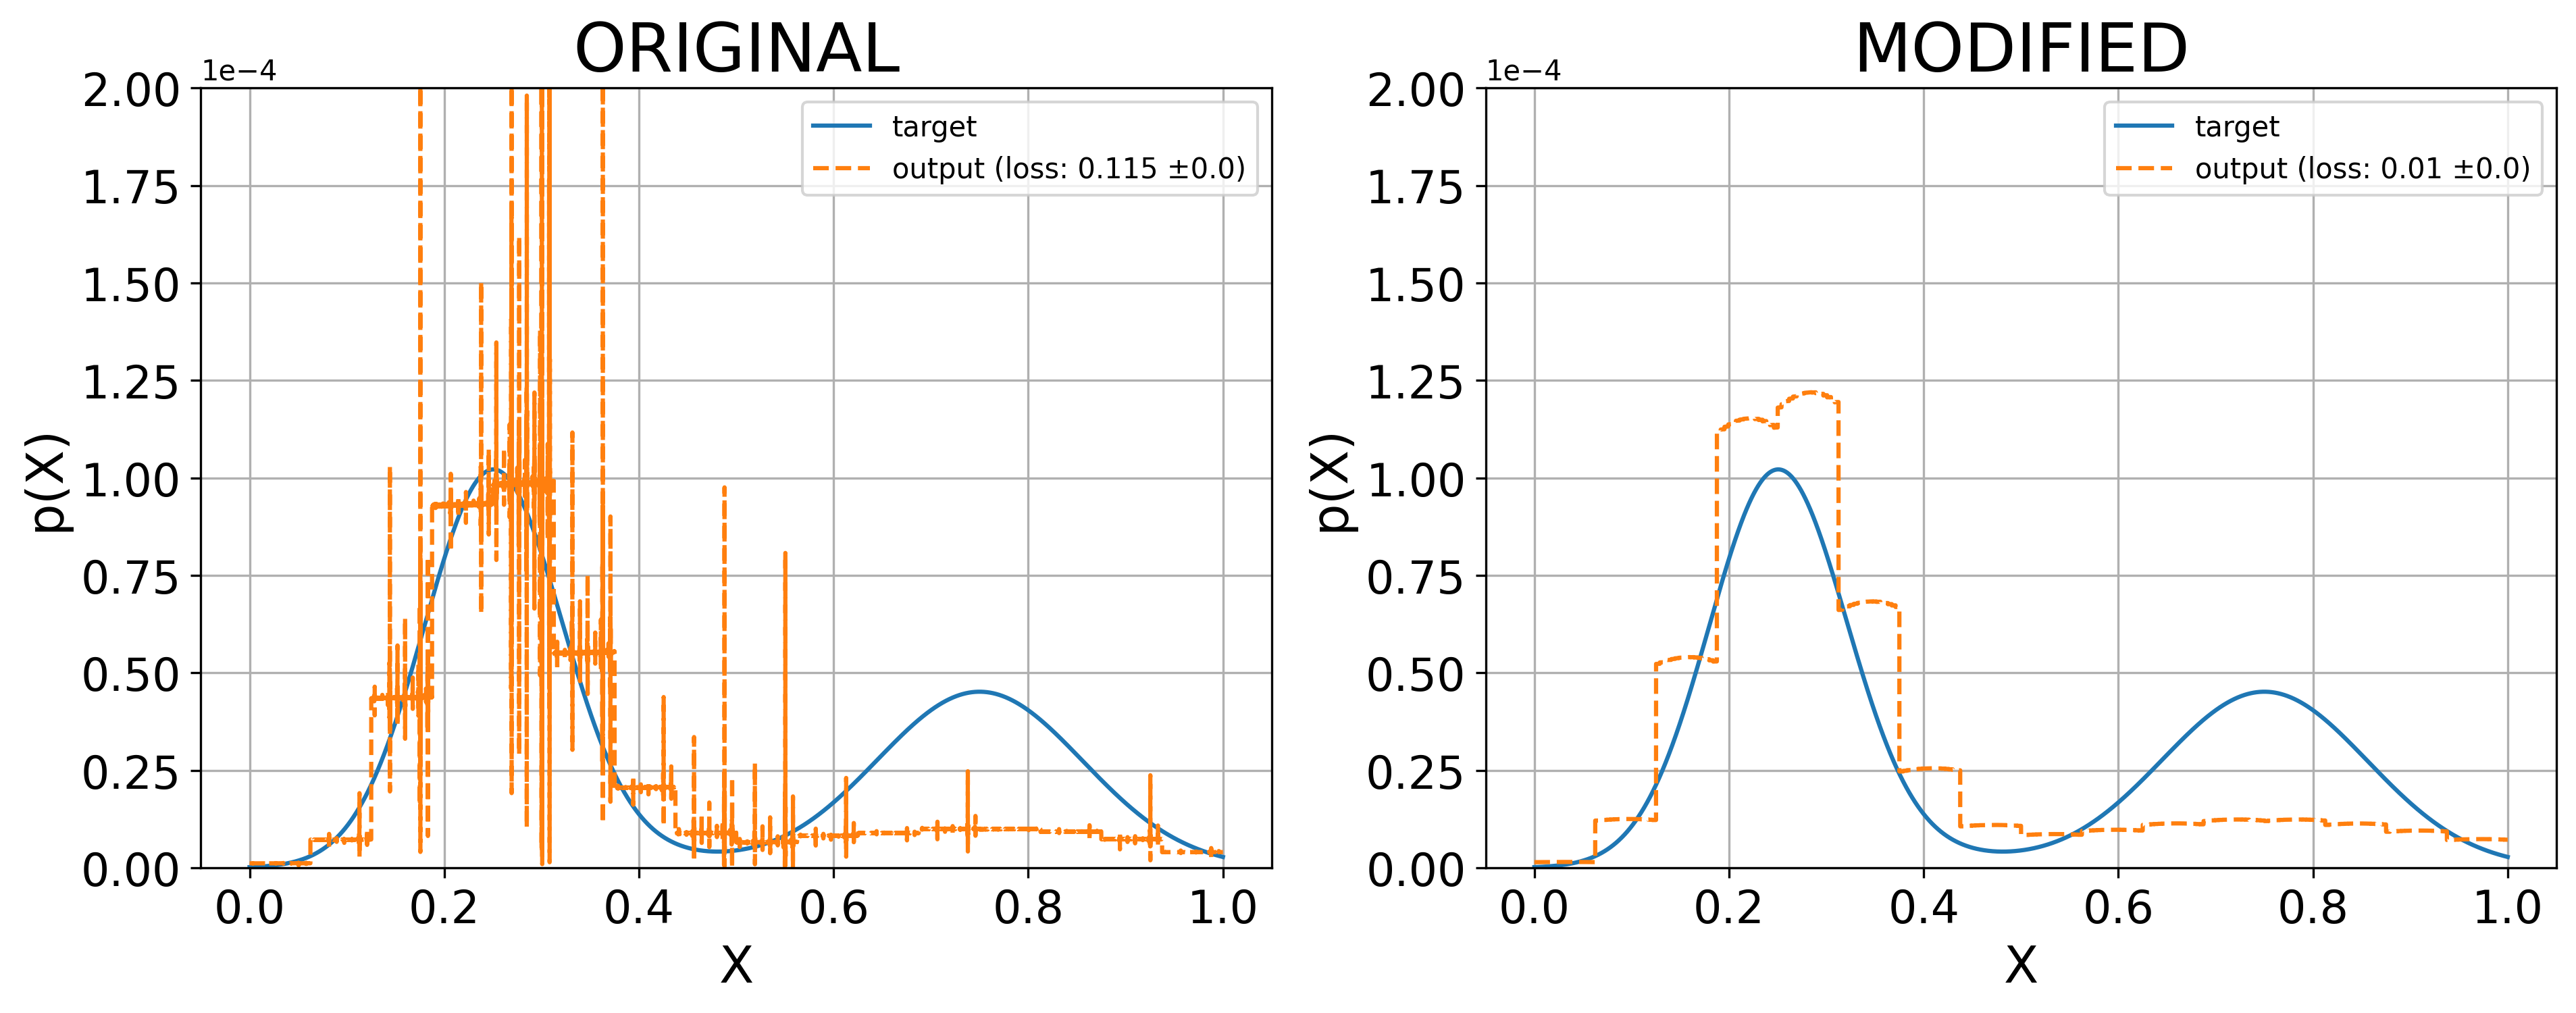

In [69]:
target_state = get_state(num_qubits=n_qubits, state_type=state_type, state_params={"x_points": (0, 1), "loc_bim1": 0.25, "scale_bim1": 0.1, "loc_bim2": 0.75, "scale_bim2": 0.15})


x_points = np.linspace(0, 1, 2**n_qubits)

target_freqs = np.abs(target_state)**2

#plt.ticklabel_format(axis="y", style="sci")
fig, axes = plt.subplots(1, 2, dpi=300)
fig.set_figheight(5)
fig.set_figwidth(15)
title_fontsize = 24
labels_fontsize= 18
ticks_fontsize = 16
axes[0].set_title("ORIGINAL", fontsize=title_fontsize)
axes[0].plot(x_points, target_freqs, label="target")
axes[0].plot(x_points, np.abs(sv_mean_original)**2, "--", label=f"output (loss: {round(df_mean_original.loc[n_qubits][eps_value], 3)} ±{round(df_stds_original.loc[n_qubits][eps_value], 2)})")
axes[0].grid()
axes[0].set_xlabel("X", fontsize=labels_fontsize)
axes[0].set_ylabel("p(X)", fontsize=labels_fontsize)
axes[0].tick_params(labelsize=ticks_fontsize)
axes[0].set_ylim([0, 0.0002])
axes[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[0].legend(loc="best")

axes[1].set_title("MODIFIED", fontsize=title_fontsize)
axes[1].plot(x_points, target_freqs, label="target")
axes[1].plot(x_points, np.abs(sv_mean_modified)**2, "--", label=f"output (loss: {round(df_mean_modified.loc[n_qubits][eps_value], 3)} ±{round(df_stds_modified.loc[n_qubits][eps_value], 2)})")
axes[1].grid()
axes[1].set_xlabel("X", fontsize=labels_fontsize)
axes[1].set_ylabel("p(X)", fontsize=labels_fontsize)
axes[1].tick_params(labelsize=ticks_fontsize)
axes[1].set_ylim([0, 0.0002])
axes[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[1].legend(loc="best")

### Laplace $(\mu = 0.5, \sigma = 0.2)$

In [70]:
state_type = "laplace"

In [71]:
original_results_dict, modified_results_dict = load_results(results_dir, state_type, qubit_range, eps_values)

mean_original_results_dict, stds_original_results_dict = compute_statistics(original_results_dict)
mean_modified_results_dict, stds_modified_results_dict = compute_statistics(modified_results_dict)

df_mean_original = to_dataframe(mean_original_results_dict)
df_stds_original = to_dataframe(stds_modified_results_dict)

df_mean_modified = to_dataframe(mean_modified_results_dict)
df_stds_modified = to_dataframe(stds_modified_results_dict)

In [72]:
display(df_mean_original)
display(df_mean_modified)

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.10510,0.10510,0.89938,0.81062
4,0.11770,0.11770,0.02689,0.95265
5,0.11710,0.11710,0.03236,0.01214
6,0.11530,0.11530,0.03583,0.01395
7,0.11410,0.11410,0.03245,0.01382
8,0.11340,0.11340,0.03188,0.01795
9,0.11300,0.11300,0.03506,0.11790
10,0.11280,0.11280,0.03207,0.11115
11,0.11270,0.11270,0.03451,0.01506


,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.1051,0.1051,0.0000,0.0000
4,0.1153,0.1153,0.0265,0.0000
5,0.1149,0.1149,0.7375,0.0064
6,0.1132,0.1132,0.0316,0.7469
7,0.1120,0.1120,0.5155,0.0080
8,0.1114,0.1114,0.0313,0.0081
9,0.1110,0.1110,0.0313,0.0081
10,0.1109,0.1109,0.0312,0.7520
11,0.1108,0.1108,0.7578,0.0081


In [73]:
df_mean_original < df_mean_modified

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,False,False,False,False
4,False,False,False,False
5,False,False,True,False
6,False,False,False,True
7,False,False,True,False
8,False,False,False,False
9,False,False,False,False
10,False,False,False,True
11,False,False,True,False


In [74]:
n_qubits = 15
eps_value = 0.01
execution_range = 10

(sv_mean_original, sv_std_original), (sv_mean_modified, sv_std_modified) = get_loaded_states(results_dir=results_dir, state_type=state_type, execution_range=execution_range, n_qubits=n_qubits, eps_value=eps_value)

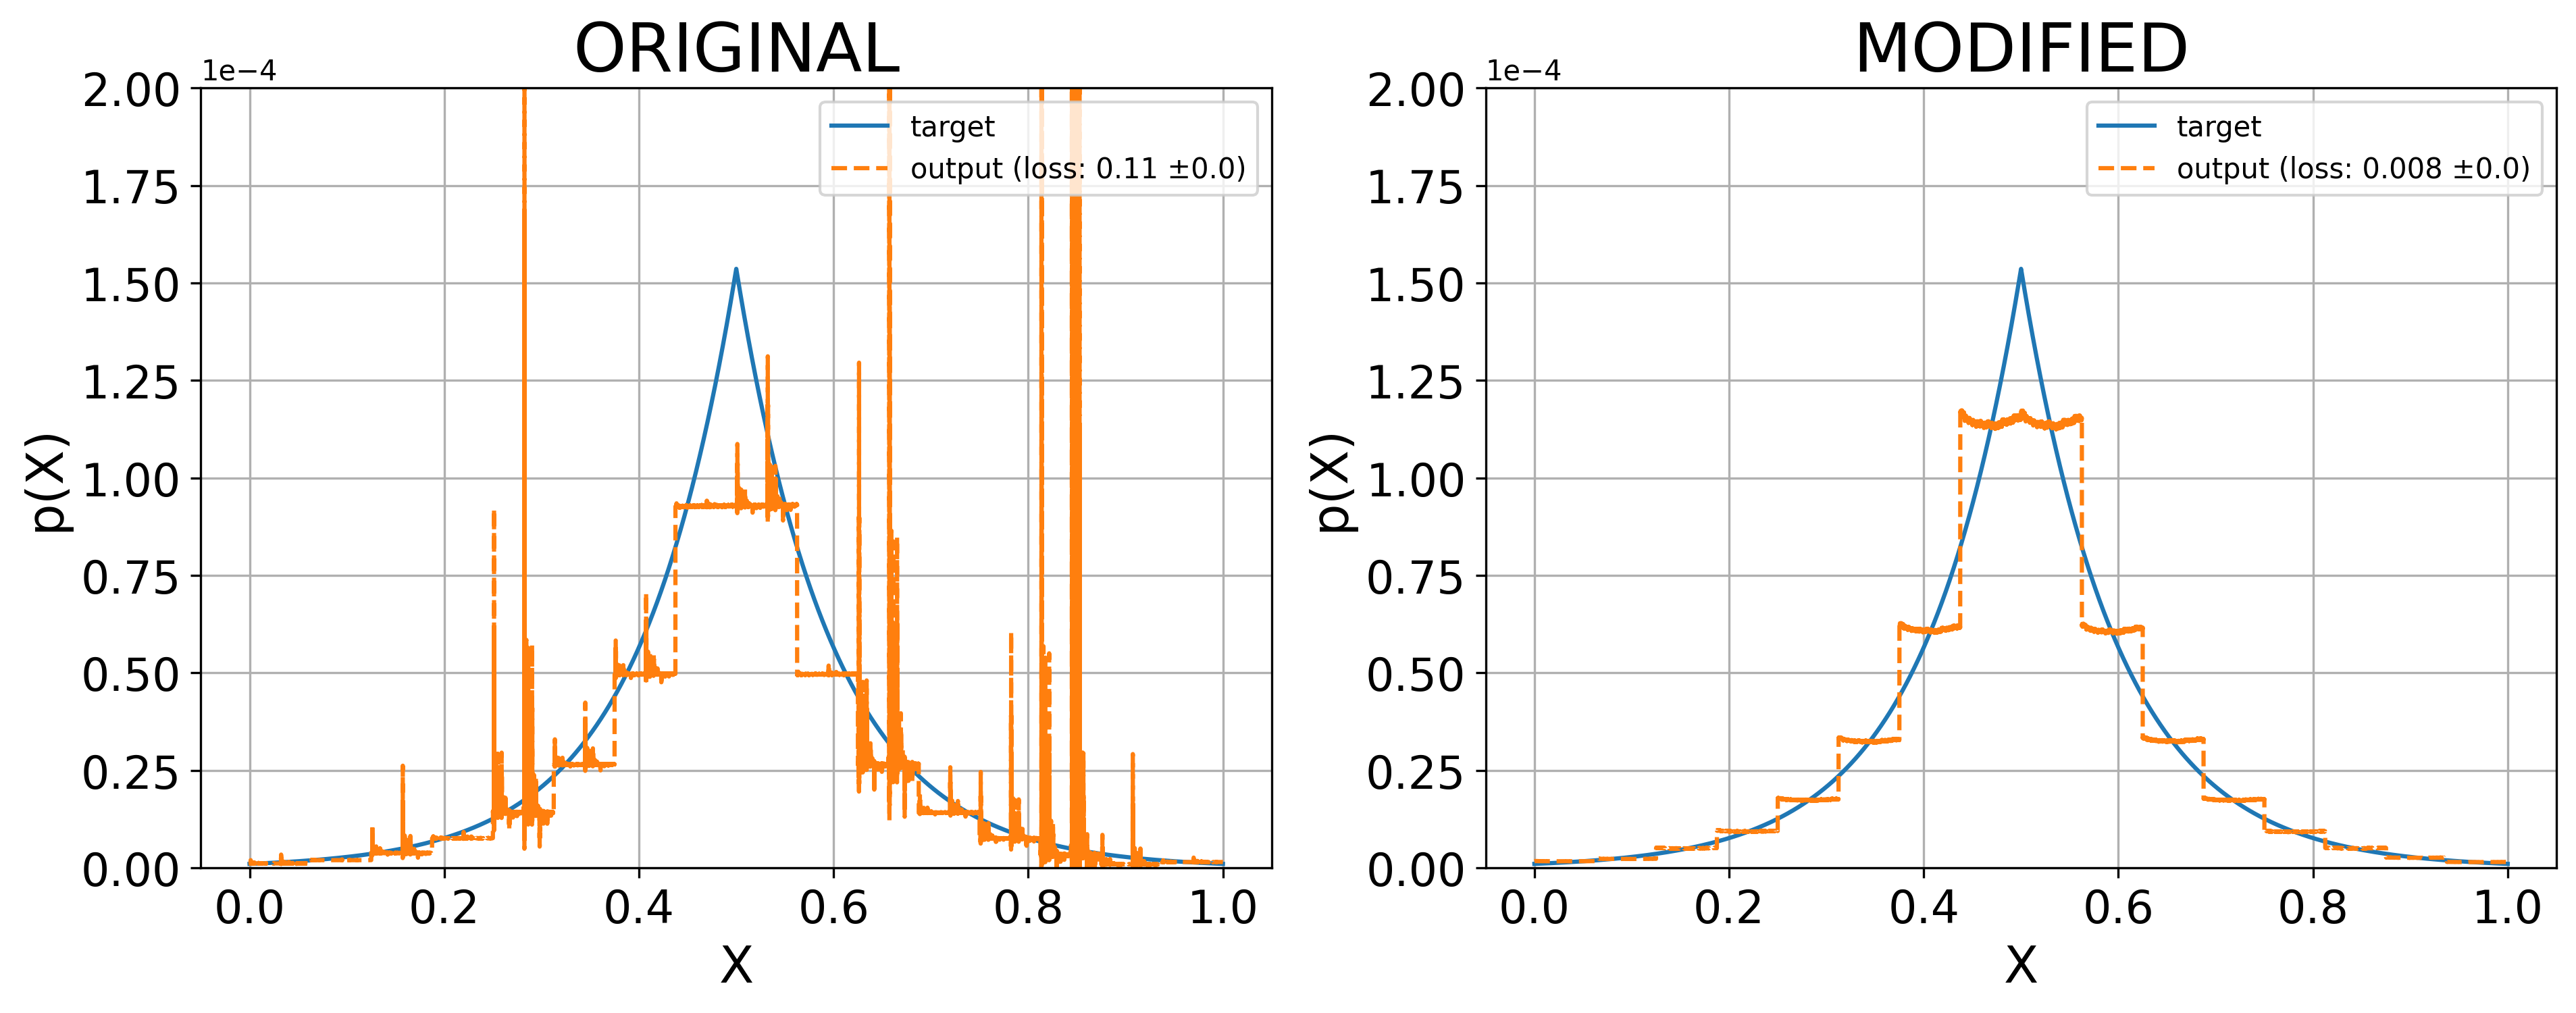

In [75]:
target_state = get_state(num_qubits=n_qubits, state_type=state_type, state_params={"x_points": (0, 1), "loc": 0.5, "scale": 0.2})


x_points = np.linspace(0, 1, 2**n_qubits)

target_freqs = np.abs(target_state)**2

#plt.ticklabel_format(axis="y", style="sci")
fig, axes = plt.subplots(1, 2, dpi=300)
fig.set_figheight(5)
fig.set_figwidth(15)
title_fontsize = 24
labels_fontsize= 18
ticks_fontsize = 16
axes[0].set_title("ORIGINAL", fontsize=title_fontsize)
axes[0].plot(x_points, target_freqs, label="target")
axes[0].plot(x_points, np.abs(sv_mean_original)**2, "--", label=f"output (loss: {round(df_mean_original.loc[n_qubits][eps_value], 3)} ±{round(df_stds_original.loc[n_qubits][eps_value], 2)})")
axes[0].grid()
axes[0].set_xlabel("X", fontsize=labels_fontsize)
axes[0].set_ylabel("p(X)", fontsize=labels_fontsize)
axes[0].tick_params(labelsize=ticks_fontsize)
axes[0].set_ylim([0, 0.0002])
axes[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[0].legend(loc="best")

axes[1].set_title("MODIFIED", fontsize=title_fontsize)
axes[1].plot(x_points, target_freqs, label="target")
axes[1].plot(x_points, np.abs(sv_mean_modified)**2, "--", label=f"output (loss: {round(df_mean_modified.loc[n_qubits][eps_value], 3)} ±{round(df_stds_modified.loc[n_qubits][eps_value], 2)})")
axes[1].grid()
axes[1].set_xlabel("X", fontsize=labels_fontsize)
axes[1].set_ylabel("p(X)", fontsize=labels_fontsize)
axes[1].tick_params(labelsize=ticks_fontsize)
axes[1].set_ylim([0, 0.0002])
axes[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[1].legend(loc="best")